In [77]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader,Dataset
from torch import nn
from PIL import Image
from torchvision import transforms
from torch.functional import F
import os

In [78]:
device=('cuda' if torch.cuda.is_available() else "cpu")
device

'cuda'

In [79]:
mask_path = 'data/CameraMask/002106.png'
image_path = 'data/CameraRGB/002106.png'
sample_img = Image.open(image_path)
sample_mask =Image.open(mask_path)

Text(0.5, 1.0, 'Segmentation')

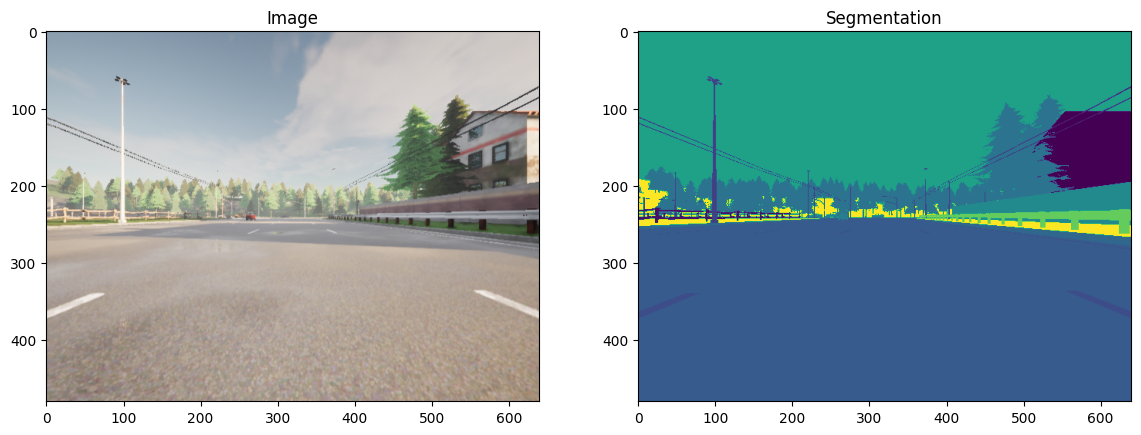

In [80]:
fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(sample_img)
arr[0].set_title('Image')
arr[1].imshow(np.array(sample_mask)[:,:,0])
arr[1].set_title('Segmentation')

In [81]:
np.array(sample_img).shape

(480, 640, 4)

In [82]:
transformations=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128)),
])
def mask_transform(mask):
    msk=transforms.functional.resize(mask, (128, 128), interpolation=Image.NEAREST)
    msk=torch.from_numpy(np.array(msk, dtype=np.int64)[:,:,0]).long()
    return msk

In [83]:
class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None,target_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_transform=target_transform

        # List of image and mask filenames
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Load image and mask
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)  # Assuming mask is grayscale
        # img, mask = process_path(image, mask)
        # img, mask = preprocess(img, mask)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask

In [84]:
image_path='data/CameraRGB/'
mask_path='data/CameraMask/'
dataset=ImageMaskDataset(image_path,mask_path,transformations,target_transform=mask_transform)

In [85]:
dataset_loader=DataLoader(dataset,batch_size=64)

torch.Size([64, 128, 128])
torch.Size([64, 3, 128, 128])


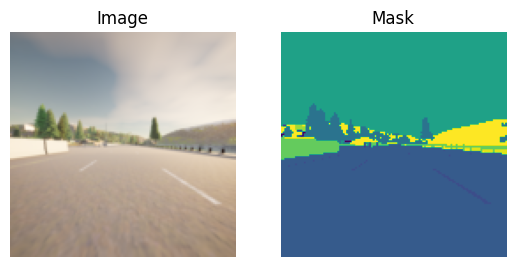

In [86]:
index=1
img,msk=None,None
for b,(image,mask) in enumerate(dataset_loader):
  img,msk=image[index],mask[index]
  print(mask.shape)
  print(image.shape)
  plt.subplot(1, 2, 1)
  plt.imshow(image[index].permute(1,2,0))
  plt.title("Image")
  plt.axis('off')
  # Plot Mask
  plt.subplot(1, 2, 2)
  plt.imshow(mask[index])
  plt.title("Mask")
  plt.axis('off')
  plt.show()
  break

In [87]:
class DownwardBlock(nn.Module):
  def __init__(self,in_channels, n_filters):
    super(DownwardBlock,self).__init__()
    self.network=nn.Sequential(
        nn.Conv2d(in_channels=in_channels,out_channels=n_filters,kernel_size=3,padding='same',bias=False),
        nn.BatchNorm2d(n_filters),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=n_filters,out_channels=n_filters,kernel_size=3,padding='same',bias=False),
        nn.BatchNorm2d(n_filters),
        nn.ReLU(inplace=True),
      )
    self.maxpool_layer=nn.MaxPool2d(kernel_size=(2,2))

  def forward(self,inputs):
    out=self.network(inputs)
    skip_connection=out
    next_layer=self.maxpool_layer(out)
    # print(next_layer.shape,skip_connection.shape)
    return next_layer,skip_connection

In [88]:
class UpwardBlock(nn.Module):
  def __init__(self,in_channels,out_channels):
    super(UpwardBlock,self).__init__()
    self.transpose=nn.ConvTranspose2d(in_channels=in_channels,out_channels=(in_channels//2),kernel_size=2,stride=2)
    self.convNet=nn.Sequential(
        nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,padding='same',bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_channels,out_channels=out_channels,kernel_size=3,padding='same',bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self,input,skip_connection):
    up=self.transpose(input)
    x=torch.cat([up,skip_connection],1)
    up=self.convNet(x)
    return up

In [89]:
class NeuralNet(nn.Module):
  def __init__(self,in_channels,n_filters=32,n_classes=23):
    super(NeuralNet,self).__init__()
    self.conBlock1=DownwardBlock(in_channels=in_channels,n_filters=n_filters)
    self.conBlock2=DownwardBlock(in_channels=n_filters,n_filters=2*n_filters)
    self.conBlock3=DownwardBlock(in_channels=2*n_filters,n_filters=4*n_filters)
    self.conBlock4=DownwardBlock(in_channels=4*n_filters,n_filters=8*n_filters)

    self.BottleNeck=DownwardBlock(in_channels=8*n_filters,n_filters=16*n_filters)

    self.transBlock1=UpwardBlock(in_channels=16*n_filters,out_channels=8*n_filters)
    self.transBlock2=UpwardBlock(in_channels=8*n_filters,out_channels=4*n_filters)
    self.transBlock3=UpwardBlock(in_channels=4*n_filters,out_channels=2*n_filters)
    self.transBlock4=UpwardBlock(in_channels=2*n_filters,out_channels=n_filters)



    #output
    self.convOut1=nn.Conv2d(in_channels=n_filters,out_channels=n_filters,padding='same',kernel_size=3)
    self.relu=nn.ReLU()
    self.convOut=nn.Conv2d(in_channels=n_filters,out_channels=n_classes,padding='same',kernel_size=1)



  def forward(self,inp):
    conv1=self.conBlock1(inp)
    conv2=self.conBlock2(conv1[0])
    conv3=self.conBlock3(conv2[0])
    conv4=self.conBlock4(conv3[0])

    conv5=self.BottleNeck(conv4[0])

    trans1=self.transBlock1(conv5[1],conv4[1])
    trans2=self.transBlock2(trans1,conv3[1])
    trans3=self.transBlock3(trans2,conv2[1])
    trans4=self.transBlock4(trans3,conv1[1])


    out=self.convOut1(trans4)
    out=self.relu(out)
    out=self.convOut(out)

    return out

model=NeuralNet(in_channels=3,n_filters=32,n_classes=23).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0003)

In [90]:
inp=torch.rand((1,3,96,128))
out=model(inp.to(device))
print(out.shape)

torch.Size([1, 23, 96, 128])


In [91]:
def train(train_loader,model,loss_fn,optimizer):
    model.train()
    loss_per_eppoc=0
    for images, labels in train_loader:
        images=images.to(device)
        labels=labels.to(device)
        # labels=labels.squeeze(1).to(device)
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(images)  # Forward pass
#         print(outputs.shape,"----",labels.shape)
        loss = loss_fn(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        loss_per_eppoc+=loss.item()
    return loss_per_eppoc/len(train_loader)

In [ ]:
epochs=30
train_loss=[]
val_loss=[]
for i in range(epochs):
    loss_train=train(dataset_loader,model,loss_fn,optimizer)
    train_loss.append(loss_train)
    print("epoch:",i+1,"-----> train Loss:",loss_train)

In [ ]:
torch.save(model.state_dict(), 'segmentation.pth')

In [75]:
model=model=NeuralNet(in_channels=3,n_filters=32,n_classes=23).to(device)
model.load_state_dict(torch.load('segmentation.pth', weights_only=True))
model.eval()

NeuralNet(
  (conBlock1): DownwardBlock(
    (network): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (maxpool_layer): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conBlock2): DownwardBlock(
    (network): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.

In [76]:
index=55
img=None
for images, labels in dataset_loader:
  img=images[index]
  break

NameError: name 'dataset_loader' is not defined

In [ ]:
img=img.unsqueeze(0)
img.shape

In [ ]:
y_hat = model(torch.FloatTensor(img).to(device))
y_hat.shape

In [ ]:
y_hat[0][3]

In [ ]:
pred = torch.max(y_hat, 1)[1]
pred.shape

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.array(img.squeeze(0).permute(1,2,0)))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(pred[0].cpu().detach().numpy())  # Assumes single channel mask
plt.title('Predicted Mask')

plt.show()

In [ ]:
#clear resources
torch.cuda.empty_cache()
import gc
del model,dataset_loader
gc.collect()